In [1]:
import os
import numpy as np
import pandas as pd

In [3]:
file_csv = "../dataset/Corona_NLP_test.csv"
dataset = pd.read_csv(file_csv,encoding="latin")
print(dataset.columns)

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')


In [5]:
dataset["Sentiment"].unique()

array(['Extremely Negative', 'Positive', 'Extremely Positive', 'Negative',
       'Neutral'], dtype=object)

In [6]:
dataset.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [7]:
  def classes_def(x):
    if x ==  "Extremely Positive":
        return "2"
    elif x == "Extremely Negative":
        return "0"
    elif x == "Negative":
        return "0"
    elif x ==  "Positive":
        return "2"
    else: #Neutral
        return "1"

In [9]:
dataset['class'] = dataset['Sentiment'].apply(lambda x:classes_def(x))

In [11]:
dataset["class"].value_counts(normalize= True)

0    0.429963
2    0.407056
1    0.162981
Name: class, dtype: float64

In [12]:
dataset.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,class
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,0
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,2
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,2
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,0
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,1


## Limpiando Texto

In [16]:
#!pip install bs4

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/josehuillca/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tqdm import tqdm
import re

In [21]:
STOPWORDS = set(stopwords.words('english'))

In [29]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def clean_tweets(list_tweet):
    preprocessed_tweets = []
    # tqdm is for printing the status bar
    for sentance in tqdm(list_tweet):
        sentance = re.sub(r'https?://\S+|www\.\S+', r'', sentance) # remove URLS
        sentance = re.sub(r'<.*?>', r'', sentance) # remove HTML
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub(r'\d+', '', sentance).strip() # remove number
        sentance = re.sub(r"[^\w\s\d]","", sentance) # remove pnctuations
        sentance = re.sub(r'@\w+','', sentance) # remove mentions
        sentance = re.sub(r'#\w+','', sentance) # remove hash
        sentance = re.sub(r"\s+"," ", sentance).strip() # remove space
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)

        sentance = ' '.join([e.lower() for e in sentance.split() if e.lower() not in STOPWORDS])
        preprocessed_tweets.append(sentance.strip())
    return preprocessed_tweets

In [30]:
preprocessed_tweets = clean_tweets(dataset['OriginalTweet'].values)

100%|██████████| 3798/3798 [00:01<00:00, 2755.49it/s]


## TF-IDF

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
tf_idf_vect = TfidfVectorizer(min_df=10)
tf_idf_vect.fit(preprocessed_tweets)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_tweets)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'absolutely', 'access', 'according', 'across', 'act', 'acting', 'action', 'activities']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (3798, 1124)
the number of unique words including both unigrams and bigrams  1124


### Split dataset

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X = final_tf_idf
y = dataset["class"].tolist()

X_train, X_test, y_train, y_test = train_test_split(X.tocsr(), y, test_size= 0.3, stratify=y,  random_state=42)

## Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
#!pip install seaborn

Accuracy: 0.6394736842105263


Text(26.5, 0.5, 'True Value')

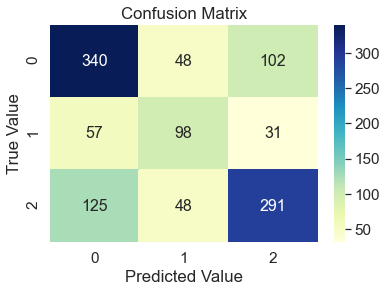

In [42]:
RandomFoest_model = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
RandomFoest_model.fit(X_train,y_train)

y_pred = RandomFoest_model.predict(X_test)
cm=confusion_matrix(y_test, y_pred)
cm_df=pd.DataFrame(cm,index=[0,1,2],columns=[0,1,2])
print("Accuracy:",accuracy_score(y_test, y_pred))

sns.set(font_scale=1.4,color_codes=True,palette="deep")
sns.heatmap(cm_df,annot=True,annot_kws={"size":16},fmt="d",cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

In [44]:
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= dataset['class'].unique()))

              precision    recall  f1-score   support

           0       0.65      0.69      0.67       490
           2       0.51      0.53      0.52       186
           1       0.69      0.63      0.66       464

    accuracy                           0.64      1140
   macro avg       0.61      0.62      0.61      1140
weighted avg       0.64      0.64      0.64      1140

